In [1]:
from routing_files.cross_modal_attention import CrossModalAttention, HatefulMemeClassifier
from routing_files.hateful_dataset import HatefulMemesClipDataset

from torch.utils.data import DataLoader
batch_size = 1024
import torch

In [2]:
import torch

cm_model = HatefulMemeClassifier()
ckpt = torch.load("best_model.pth", map_location="cpu", weights_only=False)
state = ckpt['model_state_dict']
cm_model.load_state_dict(state, strict=False)
cm_model.eval()
cm_model.to('cuda')

# -----------------------------
# TRAIN DATA
# -----------------------------
train_data = HatefulMemesClipDataset(
    cm_model, npz_path='hateful_memes_clip_embeddings_train.npz', device='cuda'
)


# -----------------------------
# TEST DATA
# -----------------------------
test_data = HatefulMemesClipDataset(
    cm_model, npz_path='hateful_memes_clip_embeddings_test.npz', device='cuda'
)

# -----------------------------
# VALID DATA
# -----------------------------
valid_data = HatefulMemesClipDataset(
    cm_model, npz_path='hateful_memes_clip_embeddings_val.npz', device='cuda'
)


# -----------------------------
# DATALOADERS
# -----------------------------
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=True)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from routing_files import capsule_layers
from routing_files.multimodal_routing import MultimodalRouting

class CapsModel(nn.Module):
    def __init__(self,
                 act_type = 'ONES', 
                 num_routing = 2,
                 dp = .5,
                 layer_norm = False,
                 t_in_dim = 768,
                 i_in_dim = 768,
                 ti_in_dim = 1024,
                 pc_dim = 64,
                 mc_caps_dim = 64,
                 mc_num_caps = 4,
                 dim_pose_to_vote = 100,
                 emb_precomputed = True):
        
        super().__init__()

        self.act_type = act_type
        self.num_routing = num_routing
        self.pc_dim = pc_dim

        # -----------------------------
        # PRIMARY CAPSULE PROJECTIONS
        # -----------------------------
        self.pc_text  = nn.Linear(t_in_dim, pc_dim + 1)
        self.pc_image = nn.Linear(i_in_dim, pc_dim + 1)


        self.use_cm = emb_precomputed
        if self.use_cm:
            self.pc_text_image = nn.Linear(ti_in_dim, pc_dim+1)
        else:
            self.text_proj = nn.Linear(t_in_dim, 512)
            self.image_proj = nn.Linear(i_in_dim, 512)
            self.pc_text_image = nn.Sequential(
                nn.ReLU(),
                nn.Dropout(dp),
                nn.Linear(512, pc_dim+1)
            )

        # -----------------------------
        # NUMBER OF DECISION CAPSULES
        # -----------------------------
        self.mc_num_caps = mc_num_caps

        self.mc_caps_dim = mc_caps_dim

        # -----------------------------
        # DECISION CAPSULE LAYER
        # -----------------------------
        self.mc = capsule_layers.CapsuleFC(
            in_n_capsules=2,                  # ONLY text + image + t_i
            in_d_capsules=pc_dim,
            out_n_capsules=self.mc_num_caps,
            out_d_capsules=mc_caps_dim,
            n_rank=None,
            dp=dp,
            act_type=act_type,
            small_std=not layer_norm,
            dim_pose_to_vote=dim_pose_to_vote,
        )
        self.routing = MultimodalRouting(num_concepts=self.mc_num_caps, num_iters=self.num_routing)
        self.W_proj = nn.Parameter(torch.randn(3, pc_dim, self.mc_num_caps, mc_caps_dim))

        # Output embedding (class prototypes)
        self.embedding = nn.Parameter(torch.zeros(self.mc_num_caps, mc_caps_dim))

        # Final bias for logits
        self.bias = nn.Parameter(torch.zeros(self.mc_num_caps))

        #self.classifier = nn.Linear(self.mc_num_caps, 1)
        self.classifier = nn.Identity()

    def forward(self, image, text, text_image):
        """
        text:  (B, t_in_dim)
        image: (B, i_in_dim)

        → both should already be extracted features (e.g., CLIP embeddings)
        """

        # -----------------------------
        # PRIMARY CAPSULES
        # -----------------------------
        u_t = self.pc_text(text).unsqueeze(1)
        u_i = self.pc_image(image).unsqueeze(1)
        if self.use_cm:
            u_tv = self.pc_text_image(text_image).unsqueeze(1)
        #
        else:
            p_t = self.image_proj(image)
            p_i = self.text_proj(text)

            text_image = p_t * p_i
            u_tv = self.pc_text_image(text_image).unsqueeze(1)
        # Combine into (B, 3, pc_dim+1)
        pc_input = torch.cat([u_t, u_i, u_tv], dim=1)

        # Pose + Activation
        init_pose = pc_input[:, :, :self.pc_dim]
        init_act  = torch.sigmoid(pc_input[:, :, self.pc_dim:])
        """
        # -----------------------------
        # ROUTING
        # -----------------------------
        pose, act, _ = self.mc(init_pose, init_act, 0)
        
        for r in range(self.num_routing):
            pose, act, routing_coeff = self.mc(init_pose, init_act, r, pose, act)

        # -----------------------------
        # CLASS LOGITS
        # -----------------------------
        pose = pose / (pose.norm(dim=-1, keepdim=True) + 1e-6)
        embedding = self.embedding / (self.embedding.norm(dim=-1, keepdim=True) + 1e-6)
        concept_logits = torch.einsum("bcd,cd -> bc", pose, embedding) + self.bias
        
        logits = self.classifier(concept_logits) 
        """

        concepts, routing_coeff = self.routing(init_pose, init_act.squeeze(-1), self.W_proj)
        concept_logits = torch.einsum("bcd,cd -> bc", concepts, self.embedding)
        logits = self.classifier(concept_logits) 

        return logits, init_act.squeeze(-1), routing_coeff, concept_logits

In [98]:
from torchmetrics.functional import auroc, f1_score

def train(train_loader, model, criterion, optimizer, device='cuda'):
    model.train()

    all_preds = []
    all_labels = []
    total_loss = 0.0
    total_size = 0
    total_correct = 0

    all_probs_binary = []   # sigmoid probabilities for AUROC
    all_labels_binary = []  # true binary labels

    for batch in train_loader:
        image_emb, text_emb, image_text_emb, labels, ids = batch
        labels = labels.float()

        # Forward pass
        logits, _, _, concept_logits = model(image_emb, text_emb, image_text_emb)
        logits = logits.squeeze(-1)
        # Loss
        loss = criterion(logits, labels)


        # AUROC uses soft probability for pos = class 1 (classes 2 or 3)
        # probability that prediction >=2:
        probs = torch.sigmoid(logits)
        preds = probs >= .5
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        scheduler.step()

        # Accuracy
        total_correct += (preds == labels).sum().item()

        # Stats
        batch_size = labels.size(0)
        total_loss += loss.item() * batch_size
        total_size += batch_size

        # Save preds for F1/AUROC
        all_probs_binary.append(probs.detach().cpu())
        all_labels_binary.append(labels.detach().cpu())

        all_preds.append(preds.detach().cpu())
        all_labels.append(labels.detach().cpu())

    # Cat all results
    all_probs_binary = torch.cat(all_probs_binary)
    all_labels_binary = torch.cat(all_labels_binary)
    all_preds = torch.cat(all_preds)

    # ---- METRICS ----
    avg_loss = total_loss / total_size
    acc = total_correct / total_size

    # Binary F1
    f1 = f1_score(all_preds, all_labels_binary, task='binary')

    # Binary AUROC
    # (requires both 0 and 1 classes to appear)
    if len(torch.unique(all_labels_binary)) == 2:
        roc = auroc(all_probs_binary, all_labels_binary.long(), task="binary")
    else:
        roc = float("nan")

    return avg_loss, acc, f1.item(), roc.item(), all_preds, all_labels


In [99]:
from torchmetrics.functional import auroc, f1_score
import torch

@torch.no_grad()
def validate(val_loader, model, criterion, device='cuda'):
    model.eval()

    all_preds_binary = []
    all_labels_binary = []
    all_probs_binary = []

    total_loss = 0.0
    total_size = 0
    total_correct = 0

    for batch in val_loader:
        image_emb, text_emb, image_text_emb, labels, ids = batch
        labels = labels.float().to(device)

        image_emb = image_emb.to(device)
        text_emb = text_emb.to(device)
        image_text_emb = image_text_emb.to(device)

        # Forward pass
        logits, pi, ri, concept_logits = model(image_emb, text_emb, image_text_emb)
        logits = logits.squeeze(-1)

        # Compute loss
        loss = criterion(logits, labels)

        # AUROC uses soft probability for pos = class 1 (classes 2 or 3)
        # probability that prediction >=2:
        probs = torch.sigmoid(logits)
        preds = probs >= .5

        # Accuracy
        total_correct += (preds == labels).sum().item()

        # Stats
        batch_size = labels.size(0)
        total_loss += loss.item() * batch_size
        total_size += batch_size

        # Save preds for F1/AUROC
        all_probs_binary.append(probs.detach().cpu())
        all_labels_binary.append(labels.detach().cpu())
        all_preds_binary.append(preds.detach().cpu())
    
    # Concatenate all predictions
    all_preds_binary = torch.cat(all_preds_binary)
    all_labels_binary = torch.cat(all_labels_binary)
    all_probs_binary = torch.cat(all_probs_binary)

    # Metrics
    avg_loss = total_loss / total_size
    acc = total_correct / total_size
    f1 = f1_score(all_preds_binary, all_labels_binary, task='binary').item()

    # AUROC (only valid if both classes appear)
    if len(torch.unique(all_labels_binary)) == 2:
        roc = auroc(all_probs_binary, all_labels_binary.long(), task="binary").item()
    else:
        roc = float("nan")

    return avg_loss, acc, f1, roc, all_preds_binary, all_labels_binary


In [134]:
model = CapsModel(dp = .5, mc_num_caps=1, emb_precomputed=True, mc_caps_dim=16, pc_dim=16)

model.to('cuda')

pos_weight = (len(train_data.labels) - train_data.labels.sum()) / train_data.labels.sum()

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 500

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-4,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.5
)


In [135]:
for epoch in range(num_epochs):
    train_loss, train_acc, train_f1, train_roc, _, _= train(train_loader, model, criterion, optimizer)
    if epoch % 49 == 0:
        val_loss, val_acc, val_f1, val_roc, _, _ = validate(valid_loader, model, criterion)
        print(f"train: {train_loss, train_acc, train_f1, train_roc}")
        print(f"val: {val_loss, val_acc, val_f1, val_roc}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x1024 and 768x17)

In [133]:
torch.save(model, "router_base_diag.pth")

In [126]:
logits, pi, routing_coeffs, concept_logits = model(valid_data.image_emb, valid_data.text_emb, valid_data.image_text_emb)
image, text, image_text = valid_data.image_emb, valid_data.text_emb, valid_data.image_text_emb

W = model.W_proj

embedding = model.embedding


with torch.no_grad():
    u_t  = model.pc_text(text).unsqueeze(1)
    u_i  = model.pc_image(image).unsqueeze(1)
    p_t = model.image_proj(image)
    p_i = model.text_proj(text)

    text_image = p_t * p_i
    u_ti = model.pc_text_image(text_image).unsqueeze(1)
pc_input = torch.cat([u_t, u_i, u_ti], dim=1)
fi = pc_input[:, :, :model.pc_dim]

votes = torch.einsum("bnd,ndcd->bncd", fi, W)

contrib = torch.einsum("bncd,cd->bnc", votes, embedding)


def get_contribution_matrix(i):
    votes = torch.einsum("bnd,ndcd->bncd", fi, W)

    contrib = torch.einsum("bncd,cd->bnc", votes, embedding)

    p_1 = pi[i].unsqueeze(1)
    r_1 = routing_coeffs[i] 
    p_r = p_1 * r_1

    contrib_sample = contrib[i]
    contribution_matrix = p_r * contrib_sample
    return contribution_matrix

In [127]:
get_contribution_matrix(2)

tensor([[0.0140],
        [0.0024],
        [0.0079]], device='cuda:0', grad_fn=<MulBackward0>)

##############################################################
Prediction: tensor([0.7312], device='cuda:0', grad_fn=<SelectBackward0>)
Actual: 1.0


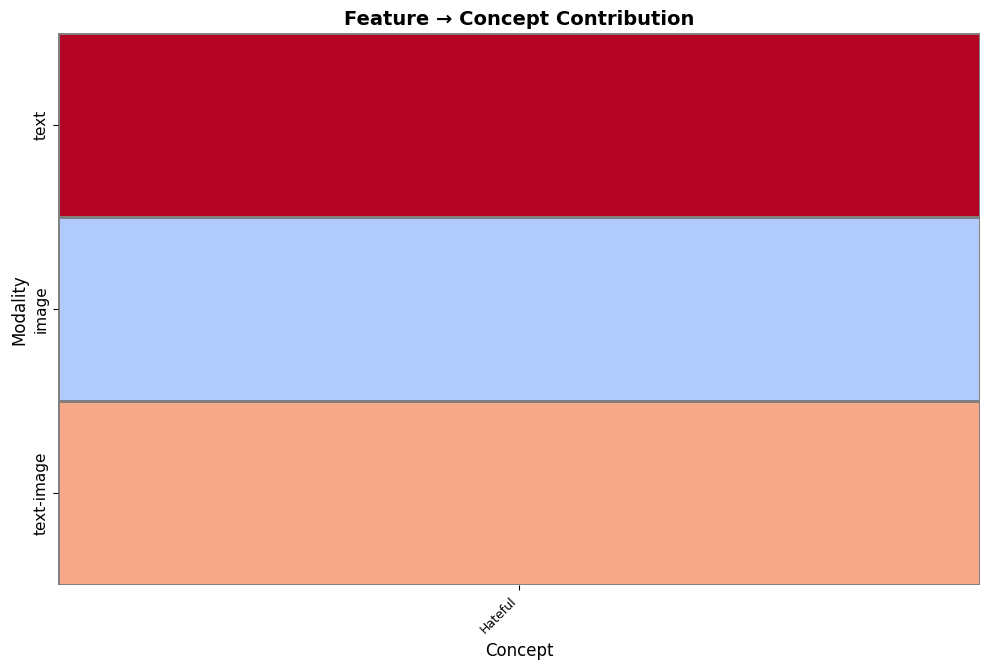

##############################################################


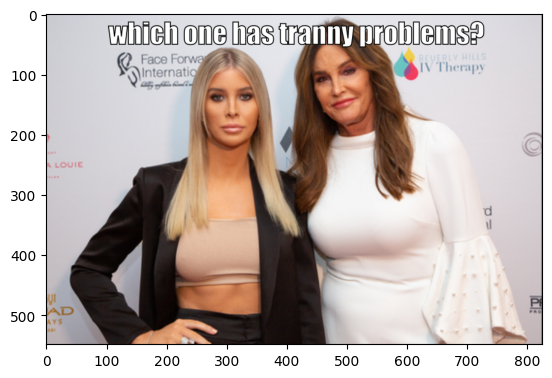

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from textwrap import wrap

def plot_contribution_heatmap(contrib_matrix, modality_names, concept_names,
                              title="Feature → Concept Contribution", 
                              annotate_threshold=0.02):

    contrib_matrix = contrib_matrix.detach().cpu().numpy()

    # Wrap long concept labels
    wrapped_labels = ['\n'.join(wrap(lbl, 12)) for lbl in concept_names]

    plt.figure(figsize=(max(10, len(concept_names)*0.6), 5 + len(modality_names)*0.6))

    ax = sns.heatmap(
        contrib_matrix,
        cmap="coolwarm",
        center=0,
        annot=False,
        linewidths=0.8,
        linecolor='gray',
        cbar=False,
        square=False,
    )

    # ---- Annotate only meaningful values ----
    for i in range(contrib_matrix.shape[0]):
        for j in range(contrib_matrix.shape[1]):
            val = contrib_matrix[i, j]

    # Set tick labels
    ax.set_xticks(np.arange(len(concept_names)) + 0.5)
    ax.set_xticklabels(wrapped_labels, rotation=45, ha="right", fontsize=9)

    ax.set_yticks(np.arange(len(modality_names)) + 0.5)
    ax.set_yticklabels(modality_names, fontsize=11)

    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel("Concept", fontsize=12)
    plt.ylabel("Modality", fontsize=12)

    plt.tight_layout()
    plt.show()

from PIL import Image
#plot_contribution_heatmap(get_contribution_matrix(2), ['Image', 'Text', 'Text-Image'], ['Non-hateful', 'Hateful'])

for cur_idx in [23]:
    print('##############################################################')
    probs = torch.sigmoid(logits)[cur_idx]
    print(f"Prediction: {probs}")
    print(f"Actual: {valid_data.labels[cur_idx]}")

    #print(logits[cur_idx])
    contrib_matrix = get_contribution_matrix(cur_idx)
    plot_contribution_heatmap(contrib_matrix, ["text", "image", "text-image"],  ['Hateful'])
    file_name = f"./data/img/{valid_data.ids[cur_idx]}.png"
    image_pil_original = Image.open(file_name)
    _ = plt.imshow(image_pil_original)
    print('##############################################################')


In [132]:
valid_data.ids[23]

np.str_('12650')

In [115]:
valid_data.labels[42]

tensor(1., device='cuda:0')